In [1]:
from purkinje.models import Purkinje
import matplotlib.pyplot as plt
from purkinje.utils import ensure_dir
plt.style.use('ggplot')
import numpy as np
import os

# Simulation 2, part 1: Pause stats by ISI¶

This notebook trains cells on various ISIs. For each ISI, cells with random parameters are trained and results are averaged. We then plot pause onset, offset and max. Pause max is deterministic if `max_type` is 'mode'; set to `mean` for more randomness. 

## Set up model and training variables. 

First, we set up some variables related to training. 

In [ ]:
# Stimulus parameters
num_steps = 8
ISIs = np.linspace(.15,.5,num_steps)
acq_trials=400
CS_onsets=[1.0]
CS_offsets=[1.35] 
ITI=10
CS_freq=50
US_freq = 500
probe_start = 50
probe_per   = 5
max_type = 'mode'

# Range for randomized cell parameters. 
tau_j1_range = [60,120]
tau_j2_range = [150,250]
a_range = [1500,2500]
c_range = [.005, .015]
num_cells = 10 # How many random cells per ISI

# Roughly how much inhibition to detect a pause (this is eyeballed)
thresh = 1.75

## Run experiments

In [45]:
exp_onsets = []
exp_offsets = []
exp_maxes = []

for ISI in ISIs:
    print('Running ISI: {}'.format(ISI))
    cell_onsets = []
    cell_offsets = []
    cell_maxes = []
    for c in range(num_cells):
        

        tau_j1 = (tau_j1_range[1] - tau_j1_range[0])*np.random.rand() + tau_j1_range[0]
        tau_j2 = (tau_j2_range[1] - tau_j2_range[0])*np.random.rand() + tau_j2_range[0]
        a = (a_range[1] - a_range[0])*np.random.rand() + a_range[0]
        c = (c_range[1] - c_range[0])*np.random.rand() + c_range[0]

        
        US_onsets=[CS_onsets[0] + ISI]
        US_offsets=[US_onsets[0] + .1]
        pk = Purkinje(tau_j1=tau_j1, tau_j2=tau_j2, a=a,c=c)
        pk.run(CS_onsets=CS_onsets, CS_offsets=CS_offsets, US_onsets=US_onsets, US_offsets=US_offsets,
               ITI=ITI, CS_freq=CS_freq, US_freq=US_freq,trials=acq_trials, verbose=False)
        
        final_I = pk.all_I[acq_trials - 1]

        on, off, mx = pk.get_pause_stats(final_I, thresh, CS_onsets[0], max_type=max_type)
        cell_onsets.append(on)
        cell_offsets.append(off)
        cell_maxes.append(mx)

    exp_onsets.append(cell_onsets)
    exp_offsets.append(cell_offsets)
    exp_maxes.append(cell_maxes)
    
exp_onsets = np.array(exp_onsets)[...,0]
exp_offsets = np.array(exp_offsets)[...,0]
exp_maxes = np.array(exp_maxes)

Running ISI: 0.15
Running ISI: 0.19999999999999998
Running ISI: 0.25
Running ISI: 0.3
Running ISI: 0.35
Running ISI: 0.39999999999999997
Running ISI: 0.44999999999999996
Running ISI: 0.5


## Plot and save reuslts

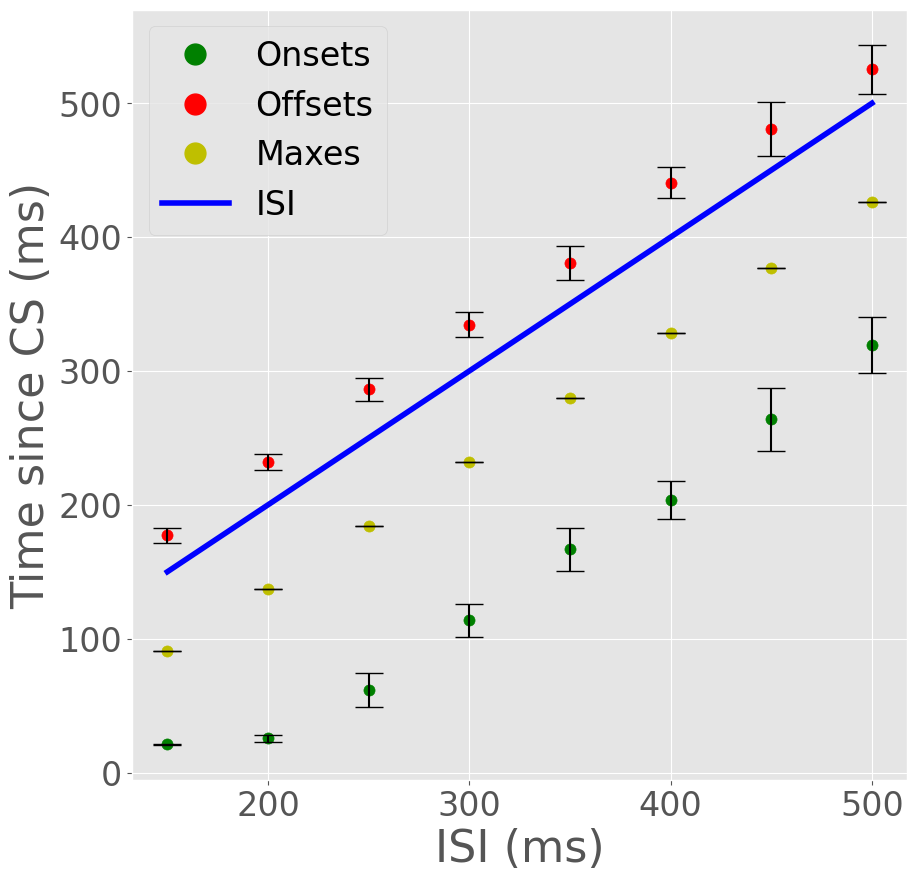

In [46]:
# Pause stats
from matplotlib.lines import Line2D

fig_save_dir = '../figures'
ensure_dir(fig_save_dir)

thresh = 1.75

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(ISIs*1000, ISIs*1000,color='b',linewidth=4)
colors = ['g', 'r', 'y']
names = ['Onsets', 'Offsets', 'Maxes']
for nm, arr, color in zip(names,[exp_onsets, exp_offsets, exp_maxes], colors):
    
    arr_means = arr.mean(1)
    arr_errs = arr.std(1)

    ax.scatter(ISIs * 1000, arr_means,c=color,s=64)
    ax.errorbar(ISIs * 1000, arr_means, yerr=arr_errs, fmt="none", capsize=10.0, ecolor='black')
    ax.set_xlabel('ISI (ms)', fontsize=32)
    ax.set_ylabel('Time since CS (ms)', fontsize=32)
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=24)
legend_elements = [ Line2D([0], [0], marker='o', label=name, linewidth=0, color=color,
                          markerfacecolor=color, markersize=15) for (name, color) in zip(names, colors)]
legend_elements += [Line2D([0], [0], color='b', lw=4, label='ISI')]


plt.legend(handles=legend_elements,fontsize=24)
plt.savefig(os.path.join(fig_save_dir, 'pause_stats.pdf'))